In [2]:
#!pip install spotify
#!pip install base64
#!pip install lyricsgenius

import spotify.sync as spotify
import base64
import datetime
import requests
from urllib.parse import urlencode
import pandas as pd
import os
current_path = os.getcwd()
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
pd.options.display.float_format = '{:20,.2f}'.format

In [3]:

# Setting up spotify credentials
spotify_client_id = '4f8887d2b1b8440a80b2135fcb761224'
spotify_client_secret = 'a9c1279440f641dd8cb8357d662d26ef'
spotify_client_creds = f'{spotify_client_id}:{spotify_client_secret}'
spotify_client_creds_b64 = base64.b64encode(spotify_client_creds.encode())
    
# Using client ID and secret to get a token to be used for each requests
# https://developer.spotify.com/documentation/general/guides/authorization-guide/#client-credentials-flow
spotify_token_url = 'https://accounts.spotify.com/api/token' 
spotify_token_data = {
    'grant_type': 'client_credentials'
}

spotify_token_headers = {
    'Authorization': f"Basic {spotify_client_creds_b64.decode()}" #<base64 encoded client_id:client_secret>
}

# Get the token with a POST request
r = requests.post(spotify_token_url, data=spotify_token_data, headers=spotify_token_headers)
valid_request = r.status_code in range(200, 299)
if valid_request:
#     now = datetime.datetime.now
    spotify_access_token = r.json()['access_token']
#     expires_in = r.json()['expires_in'] # in seconds
#     expires = now + datetime.timedelta(seconds=expires_in)
#     did_expire = expires < now

spotify_headers = {
    "Authorization": f"Bearer {spotify_access_token}"
}

In [4]:
# define function to lookup the artist and return the dictionary for the first match
def find_artist(artist_search):
    lookup_url_artist = f"https://api.spotify.com/v1/search?q={artist_search}&type=artist"
    nike_artists = requests.get(lookup_url_artist, headers=spotify_headers)
    if nike_artists.status_code == 200:
        artist_json_file = nike_artists.json()
        artist = artist_json_file['artists']['items'][0]
        artists_dict['artist_id'] = artist['id']
        artists_dict['artist_name'] = artist['name']
        artists_dict['followers'] = artist['followers']['total']
        artists_dict['genres'] = artist['genres']
        artists_dict['popularity'] = artist['popularity']
    else:
        print(nike_artists.status_code)
    return artists_dict

In [5]:
def find_artist_tracks(artist_id):
    markets = ['US', 'GB']
    track_list = []
    for m in markets:
        lookup_url_toptracks = f"https://api.spotify.com/v1/artists/{artist_id}/top-tracks?market={m}"
        artist_toptracks = requests.get(lookup_url_toptracks, headers=spotify_headers)
        if artist_toptracks.status_code == 200:
            toptracks_json_file = artist_toptracks.json()
            for t in toptracks_json_file['tracks']:
                track_list.append(t['id'])
        else:
            print (artist_toptracks.status_code)
    return set(track_list)
#ttps://api.spotify.com/v1/artists/{id}/top-tracks

In [6]:
def track_popularity(track_id):
    lookup_url_trackpop = f"https://api.spotify.com/v1/tracks/{track_id}"
    track_pop = requests.get(lookup_url_trackpop, headers=spotify_headers)
    if track_pop.status_code == 200:
        tracks_pop_json_file = track_pop.json()
        return(tracks_pop_json_file['popularity'])
    else:
        print (track_pop.status_code)
        return

In [7]:
def get_audio_features(track_ids):
    audio_features_cols = ["energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo","trackid","time_signature"]
    df_audio_features = pd.DataFrame(columns=audio_features_cols)
    for t in track_ids:
        t_id = str(t)
        lookup_url_audio = f"https://api.spotify.com/v1/audio-features/{t_id}"
        audio_features = requests.get(lookup_url_audio, headers=spotify_headers)
        audio_features_dict = {"danceability": None,"energy": None,"key": None,"loudness": None,"mode": None,"speechiness": None,"acousticness": None,"instrumentalness": None,"liveness": None,"valence": None,"tempo": None,"trackid": None,"time_signature": None}
        if audio_features.status_code == 200:
            audio_features_json_file = audio_features.json()
            audio_features_dict['trackid'] = audio_features_json_file['id']
            audio_features_dict['danceability'] = audio_features_json_file['danceability']
            audio_features_dict['energy'] = audio_features_json_file['energy']
            audio_features_dict['key'] = audio_features_json_file['key']
            audio_features_dict['loudness'] = audio_features_json_file['loudness']
            audio_features_dict['mode'] = audio_features_json_file['mode']
            audio_features_dict['speechiness'] = audio_features_json_file['speechiness']
            audio_features_dict['acousticness'] = audio_features_json_file['acousticness']
            audio_features_dict['instrumentalness'] = audio_features_json_file['instrumentalness']
            audio_features_dict['liveness'] = audio_features_json_file['liveness']
            audio_features_dict['valence'] = audio_features_json_file['valence']
            audio_features_dict['tempo'] = audio_features_json_file['tempo']
            audio_features_dict['time_signature'] = audio_features_json_file['time_signature']
            df_audio_features = df_audio_features.append(audio_features_dict, ignore_index=True)
        else:
            print('problem with ', t, " error: ", audio_features.status_code)
    return df_audio_features



In [8]:
# Define dictionary and database for artists
artists_dict = {'artist_id': None, 'artist_name': None, 'followers': None, 'genres': None, 'popularity': None}

columns_artists = ['artist_id', 'artist_name', 'followers', 'genres', 'popularity']

df_artists = pd.DataFrame(columns=columns_artists)

In [9]:
artist_list = ["Billie Eilish", "Drake", "Travis Scott", "Skepta", "G Dragon", "Kendrick Lamar", "Koffee", "Rosalia"]
for a in artist_list:
    b = a.replace(" ", "%20")
    artist_data = find_artist(b)
    df_artists = df_artists.append(artist_data, ignore_index=True)
df_artists.sort_values(by = 'followers', ascending = False)

,artist_id,artist_name,followers,genres,popularity
1,3TVXtAsR1Inumwj472S9r4,Drake,55956215,"[canadian hip hop, canadian pop, hip hop, pop ...",98
0,6qqNVTkY8uBg9cP3Jd7DAH,Billie Eilish,46159918,"[electropop, pop]",93
5,2YZyLoL8N0Wb9xBt1NhZWg,Kendrick Lamar,17794192,"[conscious hip hop, hip hop, rap, west coast rap]",89
2,0Y5tJX1MQlPlqiwlOH1tJY,Travis Scott,17477531,"[rap, slap house]",94
7,7ltDVBr6mKbRvohxheJ9h1,ROSALÍA,4754880,[r&b en espanol],83
4,30b9WulBM8sFuBo17nNq9c,G-DRAGON,2386065,"[k-pop, k-rap]",64
3,2p1fiYHYiXz9qi0JJyxBzN,Skepta,937021,"[birmingham grime, grime, instrumental grime, ...",78
6,1gWjcmBsveEYMxOZ0VRi32,Koffee,441866,"[dancehall, modern reggae]",66


In [10]:
df_artists.dtypes

artist_id      object
artist_name    object
followers      object
genres         object
popularity     object
dtype: object

In [11]:
df_artists.followers = df_artists.followers.astype(float)
df_artists.popularity = df_artists.popularity.astype(float)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Koffee'),
  Text(1, 0, 'Skepta'),
  Text(2, 0, 'G-DRAGON'),
  Text(3, 0, 'ROSALÍA'),
  Text(4, 0, 'Travis Scott'),
  Text(5, 0, 'Kendrick Lamar'),
  Text(6, 0, 'Billie Eilish'),
  Text(7, 0, 'Drake')])

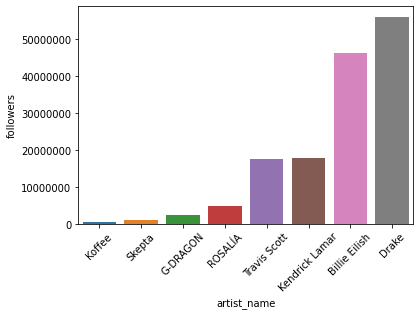

In [12]:
sns.barplot(x='artist_name',
            y="followers", 
            data=df_artists, 
            order=df_artists.sort_values('followers').artist_name)

plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.xticks(rotation = 45)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'G-DRAGON'),
  Text(1, 0, 'Koffee'),
  Text(2, 0, 'Skepta'),
  Text(3, 0, 'ROSALÍA'),
  Text(4, 0, 'Kendrick Lamar'),
  Text(5, 0, 'Billie Eilish'),
  Text(6, 0, 'Travis Scott'),
  Text(7, 0, 'Drake')])

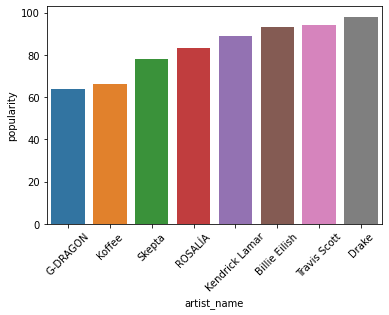

In [13]:
sns.barplot(x='artist_name',
            y="popularity", 
            data=df_artists, 
            order=df_artists.sort_values('popularity').artist_name)

plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.xticks(rotation = 45)

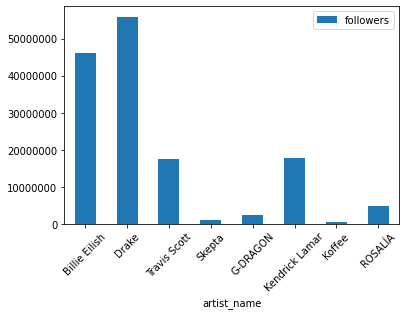

In [122]:
df_artists.sort_values(by = 'followers', ascending = False)
ax = df_artists.plot.bar(x='artist_name', y='followers', rot=0, style='plain')
plt.xticks(rotation = 45)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

In [123]:
df_artists.describe()

,followers,popularity
count,8.00,8.00
mean,"18,208,239.88",83.25
std,"21,519,754.79",12.65
min,"440,658.00",65.00
25%,"2,021,216.00",75.00
50%,"11,094,822.50",86.00
75%,"24,841,241.50",93.25
max,"55,898,930.00",98.00


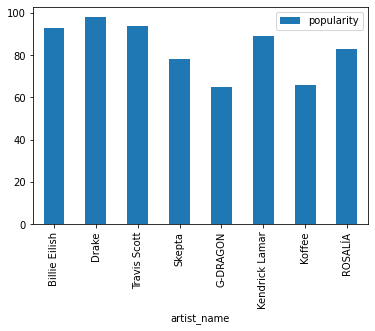

In [124]:
df_artists.sort_values(by = 'popularity', ascending = False)
ax = df_artists.plot.bar(x='artist_name', y='popularity', rot=0, style='plain')
plt.xticks(rotation='vertical')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

In [15]:
#get top songs for each artist (based off UK and US markets)
track_ids = []
artist_id_list = df_artists.artist_id
for a in artist_id_list:
    listoftracks = find_artist_tracks(a)
    for l in listoftracks:
        track_ids.append(l)


In [16]:
audio_data = get_audio_features(track_ids)
audio_data

,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,trackid,time_signature,danceability
0,0.11,4,-14.08,1,0.10,0.98,0.00,0.09,0.20,82.64,43zdsphuZLzwA9k4DJhU0I,4,0.37
1,0.37,4,-7.72,0,0.04,0.82,0.06,0.08,0.16,144.83,2uIX8YMNjGMD7441kqyyNU,4,0.47
2,0.34,10,-8.49,0,0.24,0.70,0.01,0.06,0.52,75.05,2xdwCJLfKCkat14mlgR26M,4,0.67
3,0.28,9,-14.01,0,0.08,0.94,0.00,0.23,0.20,129.65,5qNh5WtzMbfpSj2jLlBkoD,4,0.63
4,0.37,8,-9.91,1,0.07,0.33,0.54,0.11,0.59,85.02,6uqyE384HDSsuwpoF4mjrL,4,0.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.48,0,-4.78,0,0.09,0.55,0.02,0.08,0.53,97.97,1B0BQaSRHxhI0AUlItY3LK,4,0.89
81,0.69,6,-4.03,1,0.12,0.39,0.00,0.05,0.75,97.96,2qG5sZ7Si6sdK74qLxedYM,4,0.88
82,0.38,9,-10.05,0,0.36,0.89,0.00,0.10,0.77,145.95,3vgiIJW3iSQRRvgYiW86i9,4,0.54
83,0.76,1,-3.29,1,0.23,0.46,0.00,0.14,0.58,91.95,7BlBVFwvbWvcwNcUarQmjk,4,0.78


In [18]:
pop_list = []
for t in track_ids:
    track_pop = track_popularity(t)
    pop_list.append(track_pop)
audio_data['popularity'] = pop_list

In [128]:
audio_data.dtypes

energy              float64
key                  object
loudness            float64
mode                 object
speechiness         float64
acousticness        float64
instrumentalness     object
liveness            float64
valence             float64
tempo               float64
trackid              object
time_signature       object
danceability        float64
popularity            int64
dtype: object

In [129]:
# Transform column to numeric
#audio_data.loc[:, 'popularity'] = pd.to_numeric(audio_data.loc[:, ('popularity')])
#audio_data.loc[:, 'duration_ms'] = pd.to_numeric(audio_data.loc[:, ('duration_ms')])
audio_data.loc[:, 'mode'] = pd.to_numeric(audio_data.loc[:, ('mode')])

In [92]:
# Since key features is a categorical one, use one-hot-encoding
dummies = pd.get_dummies(audio_data['key'])

# Dictionary to map the key
key_dict ={0: 'C', 1: 'Db', 2: 'D', 3: 'Eb', 4: 'E', 5: 'F', 6: 'Gb', 7: 'G', 8: 'Ab', 9: 'A', 10: 'Bb', 11: 'B'}

dummies.rename(columns=key_dict, inplace=True)

KeyError: 'key'

In [130]:
# Drop key features
audio_data.drop('key', axis=1, inplace=True)

# Update categorical features columns
categorical_col = ['mode', 
                   'C', 
                   'Db', 
                   'D', 
                   'Eb',
                   'E', 
                   'F', 
                   'Gb', 
                   'G', 
                   'Ab', 
                   'A', 
                   'Bb', 
                   'B']


# Get the new database after one-hot-encoding
audio_data = pd.concat([audio_data, dummies], axis=1)



In [131]:
audio_data_plot = audio_data[['energy','loudness','mode', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo', 'danceability', 'popularity']]

In [132]:
audio_data_plot.dtypes

energy          float64
loudness        float64
mode              int64
speechiness     float64
acousticness    float64
liveness        float64
valence         float64
tempo           float64
danceability    float64
popularity        int64
dtype: object

10
0
energy
1
loudness
2
mode
3
speechiness
4
acousticness
5
liveness
6
valence
7
tempo
8
danceability
9
popularity
10
11


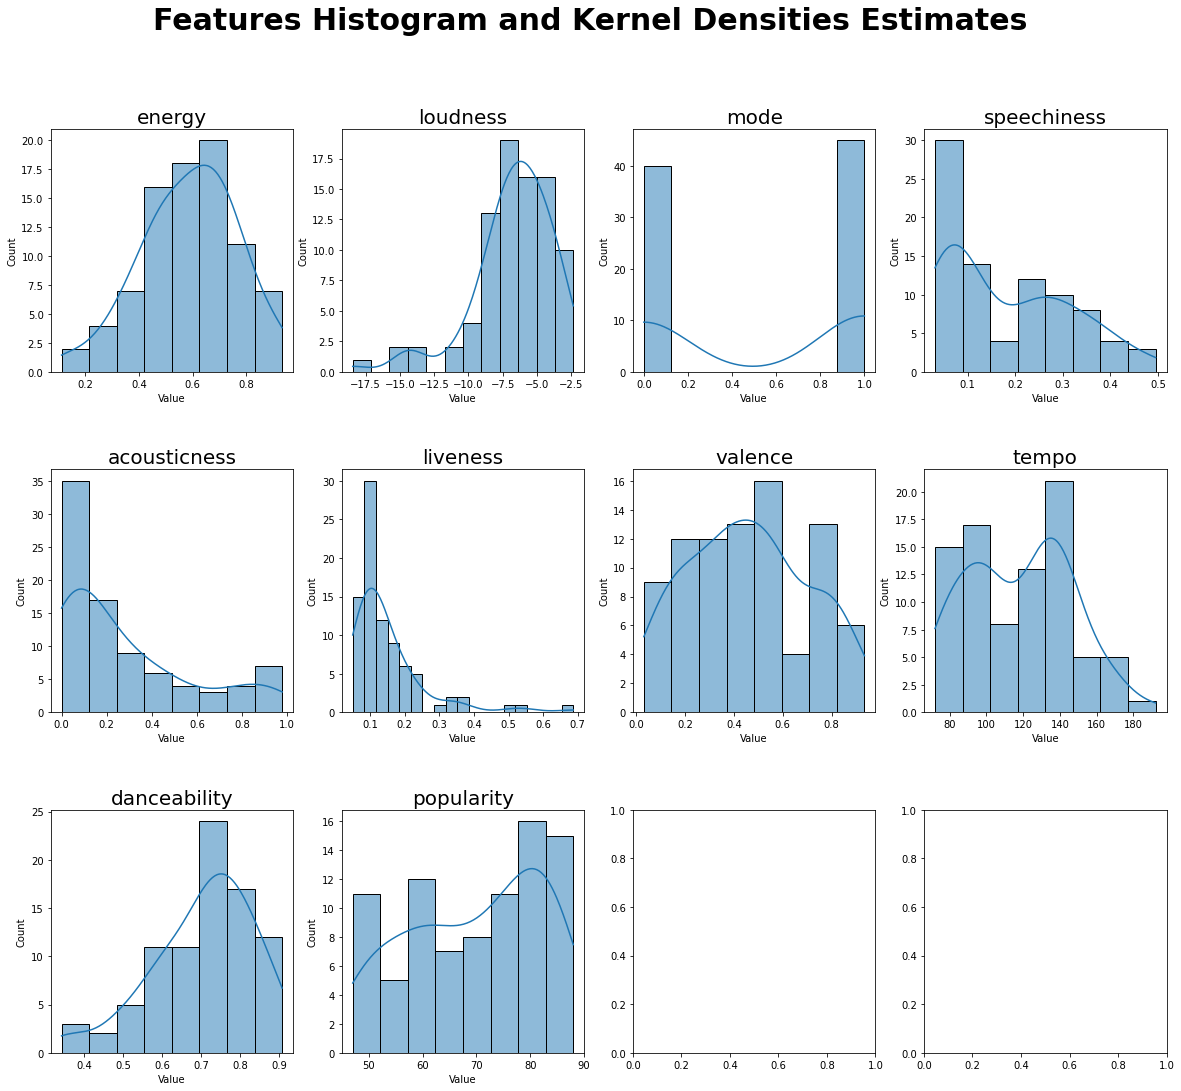

In [134]:
# Set rows and columns
nrows = 3
ncols = 4
tot_num_features = len(audio_data_plot.columns)
print(tot_num_features)

# Create figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 17))
plt.subplots_adjust(hspace=0.4)
for row in range(nrows):
    for col in range(ncols):
        i = ncols * row + col
        print (i)
        if i < tot_num_features:
            feature = audio_data[audio_data_plot.columns].columns[i]
            print(feature)
            sns.histplot(audio_data[audio_data_plot.columns][feature], kde=True, ax=ax[row,col])
            ax[row, col].set_title(label=f'{feature}', fontsize=20)
            ax[row, col].set(xlabel='Value', ylabel='Count')
        else:
            pass
plt.suptitle('Features Histogram and Kernel Densities Estimates', fontsize=30, weight='bold')
plt.show()


In [135]:
audio_data_plot.isna().sum()

energy          0
loudness        0
mode            0
speechiness     0
acousticness    0
liveness        0
valence         0
tempo           0
danceability    0
popularity      0
dtype: int64

In [136]:
# import sklearn
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
data_scaled = scale(audio_data_plot[['energy', 'loudness', 'valence', 'tempo', 'danceability', 'popularity']])
data_scaled

array([[-1.63262026e+00, -1.15441990e+00, -1.38755452e+00,
        -9.65589102e-02, -2.71717646e+00,  1.30739153e+00],
       [-1.25885549e+00, -3.10815602e-01, -1.18604245e+00,
         9.51001724e-01, -1.48866582e+00, -1.59370933e+00],
       [-1.20306971e+00, -1.08786470e+00,  5.45316330e-01,
        -1.16750639e+00,  4.61594804e-01,  1.38797767e+00],
       [-1.21980544e+00, -3.36545705e-01, -1.23539235e+00,
         9.48737340e-01, -1.76508072e+00, -4.65503439e-01],
       [-2.02869934e+00, -2.64505050e+00, -8.81718108e-01,
         7.05101696e-02, -6.77487481e-03,  1.06563313e+00],
       [-1.40947712e+00, -6.00365023e-01,  2.49216965e-01,
        -1.52004266e+00, -2.60155193e-01,  1.30739153e+00],
       [-9.12983617e-01, -1.44808613e+00,  4.30166577e-01,
         6.05541645e-01, -2.98094492e-02,  1.22680540e+00],
       [-2.66465731e+00, -2.51811533e+00, -1.06678021e+00,
        -1.25146550e+00, -2.59432539e+00,  9.85046993e-01],
       [-1.38716280e+00, -3.53012971e-01,  1.063

In [137]:
model = KMeans(n_clusters = 3, random_state= 123)
model

KMeans(n_clusters=3, random_state=123)

In [138]:
model.fit(data_scaled)

KMeans(n_clusters=3, random_state=123)

In [139]:
model.labels_

array([1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2],
      dtype=int32)

In [140]:
audio_data_plot["cluster"] = model.labels_.astype(int)

<ipython-input-140-3140fdfa3a2f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  audio_data_plot["cluster"] = model.labels_.astype(int)


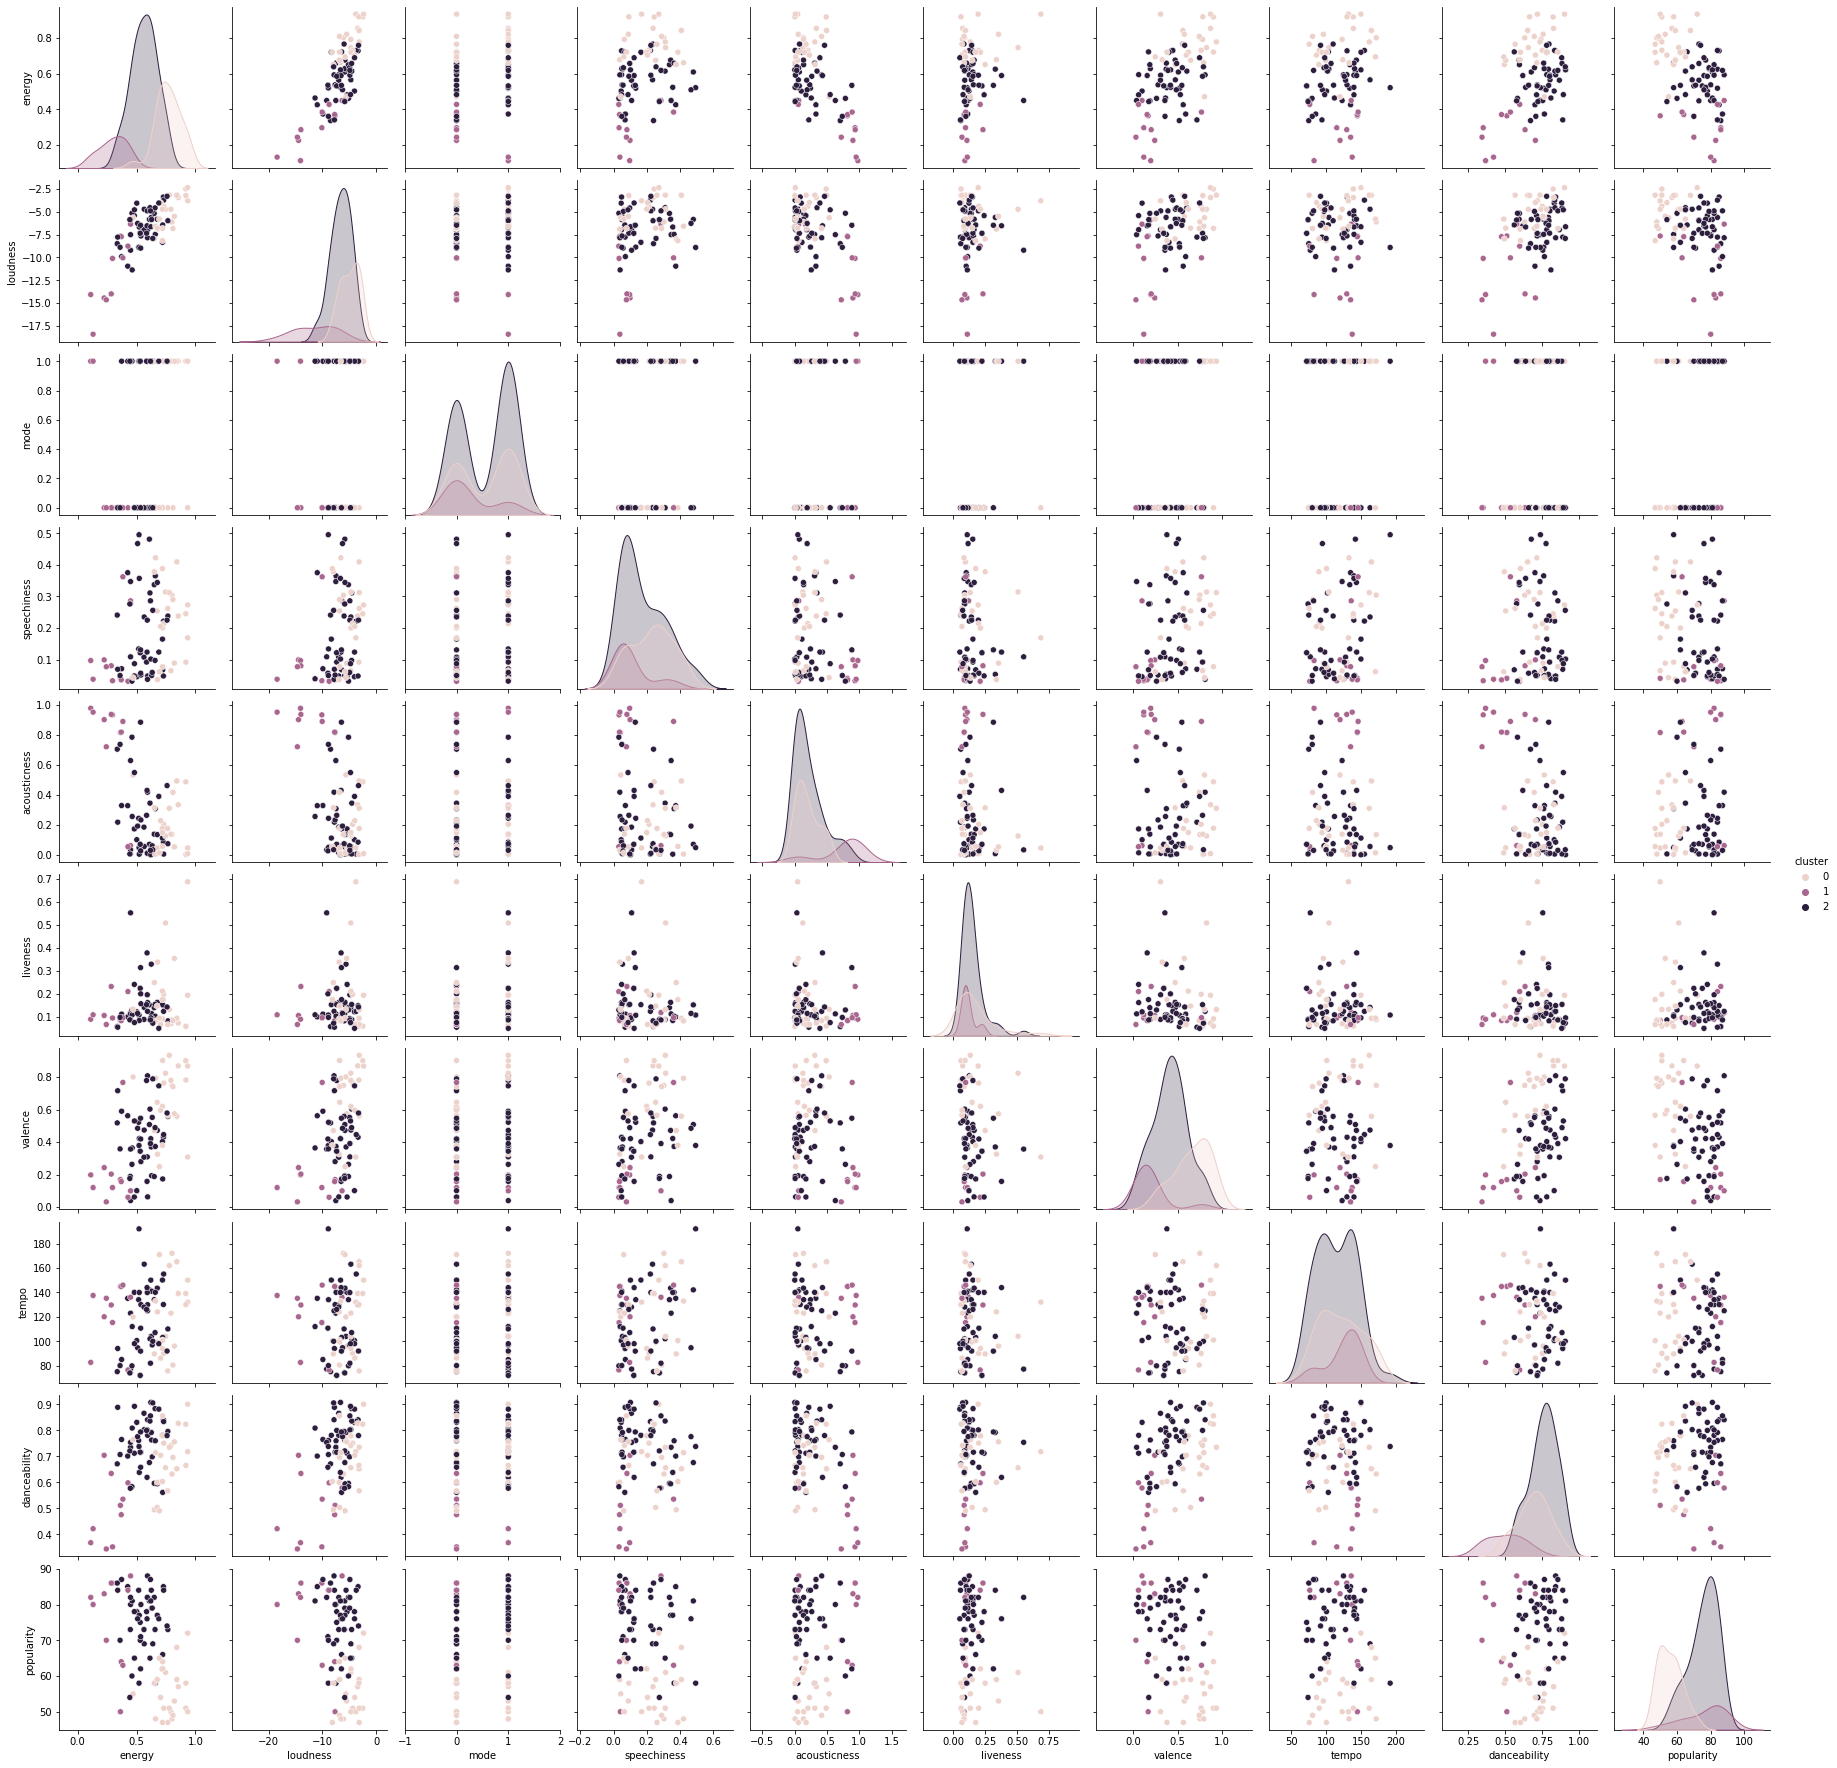

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt
pair = sns.pairplot(audio_data_plot, hue="cluster")
pair